In [1]:
import math
import random
import re
import string
import time

import contractions
import gensim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
import numpy as np
import pandas as pd
import swifter
import torch
import unidecode
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

# Sentiment Analysis on Ted Talks

In [2]:
# https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
# function to print sentiments of the sentences.
def sentiment_scores(sentence):
    # create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    # polarity_scores method of SentimentIntensityAnalyzer
    # oject gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)

    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg'] * 100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu'] * 100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos'] * 100, "% Positive")

    print("Sentence Overall Rated As", end=" ")
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05:
        print("Positive")
    elif sentiment_dict['compound'] <= -0.05:
        print("Negative")
    else:
        print("Neutral")

In [3]:
ted_main = pd.read_csv('data/ted_main.csv')
transcripts = pd.read_csv('data/transcripts.csv')
ted_merged = pd.merge(left=transcripts, right=ted_main, left_on='url', right_on='url')
transcript = ted_merged.transcript

In [4]:
def rm_num(input_str):
    return re.sub(r'\d+', '', input_str)
def remove_string_between_paran(x):
    return re.sub("([\(\[]).*?([\)\]])", "\g<1> \g<2>", x)
transcript = transcript.apply(contractions.fix) # remove contractions
transcript = transcript.str.lower() # lowercase
transcript = transcript.apply(rm_num) # remove numbers
# specials = '()'
# transcript = transcript.str.translate(str.maketrans('()',' '*len(specials))) # remove par around laughter
transcript = transcript.apply(remove_string_between_paran)
# transcript = transcript.str.translate(str.maketrans('','',string.punctuation)) # remove punctuation
transscipt = transcript.str.strip()

In [5]:
# # setiment analysis
# transscipt.swifter.apply(sentiment_scores)

In [6]:
# stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
lemma = nltk.stem.wordnet.WordNetLemmatizer()
clean_transcript = {}
for i, transcript_one in enumerate(transcript):
#     clean_transcript[i] = ' '.join(lemma.lemmatize(word) for word in word_tokenize(transcript_one) if  word not in stop_words)
    clean_transcript[i] = transcript_one.split()

# Text Generation Trial

In [7]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [8]:
test_sentence = clean_transcript[0]

In [9]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['good', 'morning.'], 'how'), (['morning.', 'how'], 'are'), (['how', 'are'], 'you?(')]


In [10]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [11]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [13]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [14]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
n_epochs = 30
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.to('cuda:0')
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

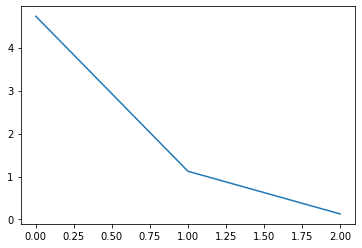

In [16]:
plt.figure()
plt.plot(all_losses)

In [17]:
def evaluate(prime_str='good morning', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [18]:
print(evaluate('good morning', 40, temperature=1))

KeyError: 'morning'

In [ ]:
print(evaluate('whole thing', 30, temperature=1))

In [ ]:
# # word2vec
# path = get_tmpfile("word2vec.model")
# model = Word2Vec(common_texts,
#                  size=256,
#                  window=5,
#                  min_count=1,
#                  workers=16,
#                  sg=1)
# model.save("word2vec.model")
# # # conti training
# # model = Word2Vec.load("word2vec.model")
# # model.train([["hello", "world"]], total_examples=1, epochs=1)

In [ ]:
# # model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
# model = KeyedVectors.load_word2vec_format('~/weight/GoogleNews-vectors-negative300.bin', binary=True)
# # model.wv['computer']